# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# df = pd.read_csv('labeled_data.csv')
# read_csv may be different depending on your folder structure
df = pd.read_csv('/content/drive/MyDrive/ML Final Project/labeled_data.csv')

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


def cleanTweets(dataframe):
  stop_words = set(stopwords.words('english'))   

  char_list = ['RT', '@']
  dataframe['tweet clean'] = dataframe['tweet']

  i = 0

  for tweet in dataframe['tweet']:
    tweet.replace('.', ' ')
    tweet.replace(',', ' ')
    temp = [ele.strip(string.punctuation) for ele in tweet.split(' ') if all(ch not in ele for ch in char_list)]
    temp = [w for w in temp if not w.lower() in stop_words]  
    temp = [t for t in temp if "&#" not in t and ';' not in t]
    temp = re.sub(r"http\S+", "", ' '.join(temp))
    dataframe['tweet clean'][i] = temp
    i = i +1
    
  return dataframe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = cleanTweets(df)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet clean
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain cleaning house amp man always ...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold...tyga dwn bad cuffin dat hoe 1...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg ever fuck bitch start cry confused shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told y...
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you's muthaf***in lie right TL trash 8230 mine...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies


In [ ]:
# extract tf-idf features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#instantiate CountVectorizer() 
cv=CountVectorizer() 

# Generates word counts for the words
word_count_vector=cv.fit_transform(df["tweet clean"])

#compute IDF values
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

def appendTfidfFeatures(dataframe):

  # count matrix 
  count_vector=cv.transform(dataframe["tweet clean"]) 
  
  # tf-idf scores 
  tf_idf_vector=tfidf_transformer.transform(count_vector)
  dataframe['tfidf vector'] = dataframe['tweet']

  for i in range(len(dataframe['tweet'])):
    dataframe['tfidf vector'][i] = tf_idf_vector[i]

  return dataframe

In [ ]:
df = appendTfidfFeatures(df)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet clean,tfidf vector
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,woman complain cleaning house amp man always ...,"(0, 19781)\t0.3495189974658263\n (0, 18272)..."
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats cold...tyga dwn bad cuffin dat hoe 1...,"(0, 18576)\t0.34749017336170746\n (0, 13487..."
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Dawg ever fuck bitch start cry confused shit,"(0, 16837)\t0.37499353611041986\n (0, 15823..."
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny,"(0, 18244)\t0.7695045098254215\n (0, 10711)..."
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told y...,"(0, 19968)\t0.21524341233011915\n (0, 18399..."
...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,you's muthaf***in lie right TL trash 8230 mine...,"(0, 20126)\t0.26020257671223784\n (0, 18272..."
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy,"(0, 19895)\t0.3313217814333724\n (0, 14539)..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like aint fuck...,"(0, 20135)\t0.33683302405027676\n (0, 19255..."
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies,"(0, 20156)\t0.5457051186690145\n (0, 19655)..."


# BERT 
(note: this part takes a long time to run, skip if you're running all and don't need new BERT representations. Embeddings were created, added to dataframe and saved to a csv in the Drive. Pull from there if you need the BERT embeddings)


In [ ]:
pip install transformers
pip install --upgrade tensorflow

import torch
from transformers import BertTokenizer, BertModel
#import logging
import matplotlib.pyplot as plt
% matplotlib inline

# BERT features
def get_bert_features():
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  # Load pre-trained model (weights)
  model = BertModel.from_pretrained('bert-base-uncased',
                                    output_hidden_states = True, # Whether the model returns all hidden-states.
                                    )
  model.eval()

  for text in df["tweet clean"]:
    if i > 5:
      break
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)
    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    # Mark each of the tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)

      # Evaluating the model will return a different number of objects based on 
      # how it's  configured in the `from_pretrained` call earlier. In this case, 
      # becase we set `output_hidden_states = True`, the third item will be the 
      # hidden states from all layers. See the documentation for more details:
      # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
      hidden_states = outputs[2]

    token_vecs = hidden_states[-2][0]

    # Calculate the average of all 22 token vectors.
    sentence_embedding = torch.mean(token_vecs, dim=0)
    df["bert"] = sentence_embedding

In [ ]:
# Word2Vec: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
import gensim
import gensim.downloader as gensim_api

# nlp = gensim_api.load("word2vec-google-news-300") - pretrained model, kinda cheating I think haha.

# Get unigrams, bigrams, and trigrams
corpus = df["tweet clean"]

# unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams and integrate into gensim.models
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

# Word2Vec model
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=50,   
            window=8, min_count=1, sg=1, iter=30)

word = "data"
nlp[word].shape



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


(50,)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

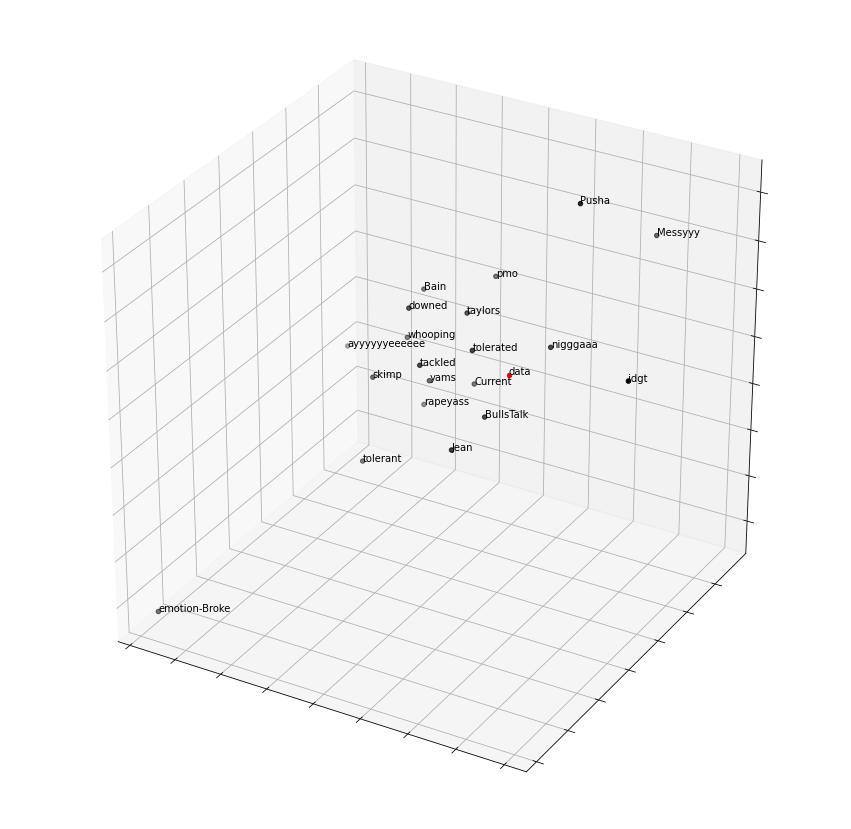

In [ ]:
# Visualize word embeddings:
import matplotlib.pyplot as plt
from sklearn import manifold

word = "data"
fig = plt.figure(figsize=(15,15))
## word embedding
tot_words = [word] + [tupla[0] for tupla in nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

def constructFeatureMatrix(option, dataframe):
  y = dataframe['class']

  # to address imbalanced data - https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
  rus = RandomUnderSampler(sampling_strategy='not minority', random_state = 1)

  if (option == 'tfidf'):
    X = np.zeros((len(dataframe), dataframe['tfidf vector'][0].shape[1]))
    for i in range(len(dataframe)):
        X[i,:] = dataframe['tfidf vector'][i].todense()
    
    X_new, y_new = rus.fit_resample(X, y)
    return X_new, y_new
  elif (option == 'word2vec'):
    X = np.zeros((len(dataframe), 50 * 20))
    for i in range(len(dataframe)):
      split_words = dataframe["tweet clean"][i].split()
      for j in range(len(split_words)):
        if (j == 20):
          break
        else:
          X[i,50*j:50*(j+1)] = nlp[split_words[j]]
    X_new, y_new = rus.fit_resample(X, y)
    return X_new, y_new


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# 5-fold cross validation - https://www.askpython.com/python/examples/k-fold-cross-validation

#!pip install imbalanced-learn
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
def calculateKFoldAccuracy(features, labels):
    k = 5
    kf = KFold(n_splits=k, random_state=None)
    model1 = LogisticRegression()
    model2 = LinearSVC()
    model3 = SVC(kernel='rbf')
    # check if X has all of the features 
    lr_acc = cross_val_score(model1, features, labels, cv = kf)
    svm_acc = cross_val_score(model2, features, labels, cv = kf)
    rbf_acc = cross_val_score(model3, features, labels, cv = kf)

    print("Logistic Regression Average Accuracy: " + str(lr_acc.mean()))
    print("SVM Average Accuracy: " + str(svm_acc.mean()))
    print("RBF Average Accuract: " + str(rbf_acc.mean()))

# Preliminary KFold Calculation:
# X_tfidf, y = constructFeatureMatrix('tfidf', df)
# calculateKFoldAccuracy(X_tfidf, y)
# X_word2vec, y = constructFeatureMatrix('word2vec', df)
# calculateKFoldAccuracy(X_word2vec, y)

In [ ]:
# Hyperparameter Sweep
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

def bestHyperparameters(best_params_list, model_type):
  max_iterations = []
  regularizers = []
  for param in best_params_list:
    max_iterations.append(param['max_iter'])
    if (model_type == 'rbf'):
      regularizers.append(param['C'])
    else:
      regularizers.append(param['penalty'])

  counter1 = Counter(max_iterations)
  max_count1 = max(counter1.values())
  mode1 = [k for k, v in counter1.items() if v == max_count1]

  counter2 = Counter(regularizers)
  max_count2 = max(counter2.values())
  mode2 = [k for k, v in counter2.items() if v == max_count2]

  return mode1[0], mode2[0]

def determineHyperparameters(features, labels, feature_type, model_type):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    if (model_type == 'logistic'):
      param_grid = {'max_iter': [200, 300, 400, 500], 'penalty': ['l2', 'none']}
      model = LogisticRegression()
    elif (model_type == 'linear_svc'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'penalty': ['l2', 'l1']}
      model = LinearSVC()
    elif (model_type == 'rbf'):
      param_grid = {'max_iter': [500, 1000, 1500, 2000], 'C': [0.5, 1.0]}
      model = SVC(kernel='rbf')

    best_params = []

    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_valid=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_valid=[labels[ii] for ii in test_indices]

        #I train the classifier
        trained=model.fit(X_train,y_train)

        hp_search = RandomizedSearchCV(estimator = trained, param_distributions=param_grid)
        hp_search.fit(X_valid, y_valid)
        best_params.append(hp_search.best_params_)

        break

    parameter1, parameter2 = bestHyperparameters(best_params, model_type)

    return_dict = {'max_iter': parameter1, 'penalty': parameter2}

    # Save these hyperparameters
    np.save(f'{model_type}_{feature_type}_params.npy', return_dict)

    return return_dict

In [ ]:
def perf_measure(y_actual, y_hat):
    # Used for calculating certain statistics
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    positives = 0
    negatives = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
           positives += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
           positives += 1
        if (y_actual[i]==y_hat[i]==1) or (y_actual[i]==y_hat[i]==2):
           TN += 1
           negatives += 1
        if (y_hat[i]==1 or y_hat[i]==2) and y_actual[i]==0:
           FN += 1
           negatives += 1

    TP = TP / positives
    FP = FP / positives
    TN = TN / negatives
    FN = FN / negatives

    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1 = (2*precision*recall) / (precision + recall)

    return np.array([TP, FP, TN, FN, recall, precision, f1])

In [ ]:
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns

# Will not be using cross_val_score here:
#I generate a KFold in order to make cross validation
def generateModel(features, labels, model_name, model_type):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    hyperparameter_list = np.load(f'{model_type}_{model_name}_params.npy', allow_pickle=True).item()

    ac = 0
    cm = np.zeros((3,3))
    stats = np.zeros(7)

    #I start the cross validation
    for train_indices, test_indices in kf.split(features):
        X_train=[features[ii] for ii in train_indices]
        X_test=[features[ii] for ii in test_indices]
        y_train=[labels[ii] for ii in train_indices]
        y_test=[labels[ii] for ii in test_indices]

        if (model_type == 'logistic'):
          model = LogisticRegression(max_iter = hyperparameter_list['max_iter'], penalty = hyperparameter_list['penalty'])
        elif (model_type == 'linear_svc'):
          model = LinearSVC(max_iter = hyperparameter_list['max_iter'], penalty = hyperparameter_list['penalty'])
        elif (model_type == 'rbf'):
          model = SVC(kernel='rbf', max_iter = hyperparameter_list['max_iter'], C = hyperparameter_list['penalty'])
        
        #I train the classifier
        trained=model.fit(X_train,y_train)

        # Save model
        pickle.dump(model, open(f"{model_type}_{model_name}.model", 'wb'))

        #I make the predictions
        predicted=model.predict(X_test)

        #I obtain the accuracy of this fold
        ac += accuracy_score(predicted,y_test)

        #I obtain the confusion matrix
        cm += confusion_matrix(y_test, predicted, normalize = 'true')

        #I should calculate the TP,TN, FP and FN 
        stats += perf_measure(y_test, predicted)

    ac = ac / 5
    cm = cm / 5
    stats = stats / 5

    print('Accuracy: ' + str(ac))
    print('Logistic Regression [TP, FP, TN, FN, recall, precision, f1: ')
    print(stats)
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

    return [ac, cm, stats]

In [ ]:
X_tfidf, y = constructFeatureMatrix('tfidf', df)
X_word2vec, y = constructFeatureMatrix('word2vec', df)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
determineHyperparameters(X_tfidf, y, 'tfidf', 'logistic')
determineHyperparameters(X_word2vec, y, 'word2vec', 'logistic')
determineHyperparameters(X_tfidf, y, 'tfidf', 'linear_svc')
determineHyperparameters(X_word2vec, y, 'word2vec', 'linear_svc')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use G

ValueError: ignored

In [ ]:
determineHyperparameters(X_tfidf, y, 'tfidf', 'rbf')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3

{'max_iter': 500, 'penalty': 1.0}

In [ ]:
determineHyperparameters(X_word2vec, y, 'word2vec', 'rbf')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'max_iter': 500, 'penalty': 1.0}

Accuracy: 0.7993006993006994
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.78794313 0.21205687 0.83941794 0.16058206 0.83072813 0.78794313
 0.80865667]


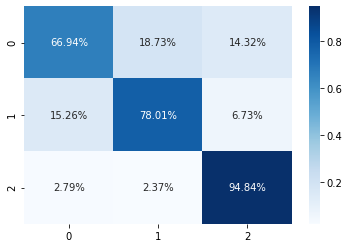

In [ ]:
list1 = generateModel(X_tfidf, y, 'tfidf', 'logistic')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.6263403263403263
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.57555502 0.42444498 0.74558188 0.25441812 0.69353855 0.57555502
 0.62888215]


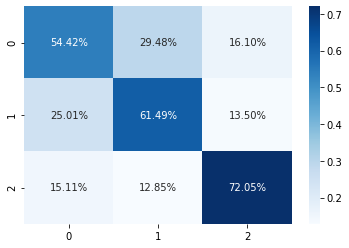

In [ ]:
list2 = generateModel(X_word2vec, y, 'word2vec', 'logistic')

Accuracy: 0.7773892773892774
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.74377952 0.25622048 0.84166984 0.15833016 0.82460936 0.74377952
 0.78185914]


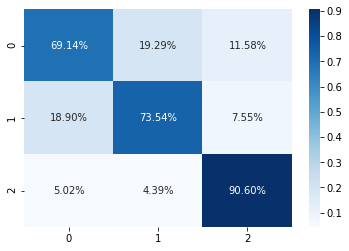

In [ ]:
list3 = generateModel(X_tfidf, y, 'tfidf', 'linear_svc')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Accuracy: 0.6214452214452215
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.57115926 0.42884074 0.73835825 0.26164175 0.68562984 0.57115926
 0.62306755]


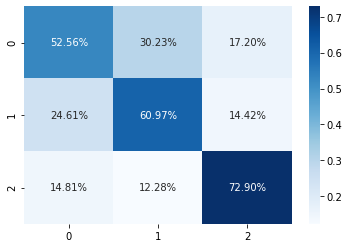

In [ ]:
list4 = generateModel(X_word2vec, y, 'word2vec', 'linear_svc')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base

Accuracy: 0.7881118881118881
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.73450901 0.26549099 0.85190764 0.14809236 0.83196163 0.73450901
 0.78002985]


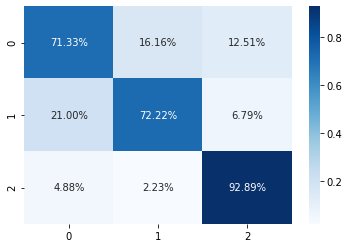

In [ ]:
list5 = generateModel(X_tfidf, y, 'tfidf', 'rbf')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base

Accuracy: 0.6811188811188812
Logistic Regression [TP, FP, TN, FN, recall, precision, f1: 
[0.66104708 0.33895292 0.7499302  0.2500698  0.72568974 0.66104708
 0.69164872]


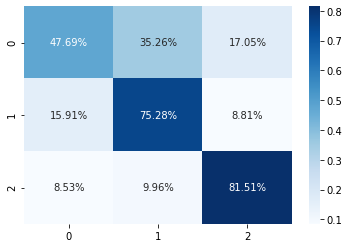

In [ ]:
list6 = generateModel(X_word2vec, y, 'word2vec', 'rbf')

In [ ]:
# @Gina: use this to load a model to predict Trump's tweets:
import pandas as pd

df2 = pd.read_csv('/content/drive/MyDrive/ML Final Project/TrumpTweets.csv')

In [ ]:
df2 = cleanTweets(df2)
df2 = appendTfidfFeatures(df2)
df2

,date,tweet,tweet clean,tfidf vector
0,2020-10-12 10:53:00,"Remember, I wouldn’t be President now had Obam...",Remember wouldn’t President Obama Biden proper...,"(0, 19859)\t0.40802133225618636\n (0, 17687..."
1,2020-10-12 10:58:00,STOCK MARKET UP BIG!,STOCK MARKET BIG,"(0, 16958)\t0.6495999429654231\n (0, 11104)..."
2,2020-10-12 11:39:00,So Crazy to watch Senator Blumenthal of Connec...,Crazy watch Senator Blumenthal Connecticut lec...,"(0, 20053)\t0.17331599536930617\n (0, 19308..."
3,2020-10-12 11:50:00,https://t.co/599e8A6ogf,,
4,2020-10-12 11:55:00,Republicans must state loudly and clearly that...,Republicans must state loudly clearly going pr...,"(0, 19813)\t0.18244568895965413\n (0, 16850..."
...,...,...,...,...
991,2020-11-03 02:30:00,Thank you Matt! https://t.co/hWiyWpvf8o,Thank Matt,"(0, 17731)\t0.5963448965315192\n (0, 11178)..."
992,2020-11-03 02:30:00,RT @PastorDScott: VOTE TRUMP!!!!!! https://t.c...,VOTE TRUMP,"(0, 19156)\t0.6252381550675243\n (0, 18408)..."
993,2020-11-03 02:31:00,RT @PastorDScott: We need to set all time reco...,need set time records voter turnout tomorrow P...,"(0, 19159)\t0.32350504277270264\n (0, 19156..."
994,2020-11-03 02:57:00,VOTE! VOTE! VOTE!\nhttps://t.co/85ySh1KYkh,VOTE VOTE VOTE!\n,"(0, 19156)\t1.0"


In [ ]:
df2 = df2[df2['tweet clean'] != '']
df2 = df2.reset_index()
df2

,index,date,tweet,tweet clean,tfidf vector
0,0,2020-10-12 10:53:00,"Remember, I wouldn’t be President now had Obam...",Remember wouldn’t President Obama Biden proper...,"(0, 19859)\t0.40802133225618636\n (0, 17687..."
1,1,2020-10-12 10:58:00,STOCK MARKET UP BIG!,STOCK MARKET BIG,"(0, 16958)\t0.6495999429654231\n (0, 11104)..."
2,2,2020-10-12 11:39:00,So Crazy to watch Senator Blumenthal of Connec...,Crazy watch Senator Blumenthal Connecticut lec...,"(0, 20053)\t0.17331599536930617\n (0, 19308..."
3,4,2020-10-12 11:55:00,Republicans must state loudly and clearly that...,Republicans must state loudly clearly going pr...,"(0, 19813)\t0.18244568895965413\n (0, 16850..."
4,5,2020-10-12 12:47:00,The Economy is about ready to go through the r...,Economy ready go roof Stock Market ready break...,"(0, 19263)\t0.15940299935352784\n (0, 19156..."
...,...,...,...,...,...
857,990,2020-11-03 02:28:00,RT @GOP: “Let’s Make America Great Again and r...,“Let’s Make America Great re-elect fantastic p...,"(0, 14423)\t0.30206434685864925\n (0, 13845..."
858,991,2020-11-03 02:30:00,Thank you Matt! https://t.co/hWiyWpvf8o,Thank Matt,"(0, 17731)\t0.5963448965315192\n (0, 11178)..."
859,992,2020-11-03 02:30:00,RT @PastorDScott: VOTE TRUMP!!!!!! https://t.c...,VOTE TRUMP,"(0, 19156)\t0.6252381550675243\n (0, 18408)..."
860,993,2020-11-03 02:31:00,RT @PastorDScott: We need to set all time reco...,need set time records voter turnout tomorrow P...,"(0, 19159)\t0.32350504277270264\n (0, 19156..."


In [ ]:
X_trump = np.zeros((len(df2), df2['tfidf vector'][0].shape[1]))
for i in range(len(df2)):
    X_trump[i,:] = df2['tfidf vector'][i].todense()

In [ ]:
import pickle
model_trump1 = pickle.load(open("logistic_tfidf.model", 'rb'))
prediction1 = model_trump1.predict(X_trump)

In [ ]:
model_trump2 = pickle.load(open("linear_svc_tfidf.model", 'rb'))
prediction2 = model_trump2.predict(X_trump)

In [ ]:
model_trump3 = pickle.load(open("rbf_tfidf.model", 'rb'))
prediction3 = model_trump3.predict(X_trump)

In [ ]:
for i in range(len(prediction1)):
  sum1 = int((prediction1 == 0)[i]) + int((prediction2 == 0)[i]) + int((prediction3 == 0)[i])
  sum2 = int((prediction1 == 1)[i]) + int((prediction2 == 1)[i]) + int((prediction3 == 1)[i])
  tweet = df2['tweet'][i]
  if (sum1 == 3):
    print(f'Hate {sum1}: {tweet}')
  if (sum2 == 3):
    print(f'Offensive {sum2}: {tweet}')

Hate 3: RT @GOPChairwoman: .@realDonaldTrump delivers for all Americans! https://t.co/AwUaHDyDYS
Hate 3: RT @thesamsorbo: Sen Ron Johnson just released his report on Biden’s corruption with China, Ukraine, and Russia. Fox doesn’t report about it, absurd. 
RT if you believe Americans deserve to know the truth
Hate 3: RT @TrumpWarRoom: “The white race is a superior race, and the Negro race is an inferior race,” said Democrat Senator James Eastland.

Joe Biden spoke fondly of this racist TODAY: https://t.co/ZzbMSQGt1o
Hate 3: Proud citizens like you helped build this Country—and together, we are taking back our Country. We are returning power to YOU, the American People! #MAGA https://t.co/rn69eJJAPV
Hate 3: Just left the White House, on my way to the Great State of Iowa! https://t.co/fSphwlO7QI
Hate 3: I was thrilled to be back in the American Heartland with thousands of loyal, hardworking IOWA Patriots! 20 days from now, we are going to win IOWA, and we are going to win 4 more years in 